# Price Forecasting: Complete Model Comparison

## Project: Yield Sync - Agricultural Price Prediction System

**Objective:** Predict daily crop prices for Sri Lankan markets using Machine Learning.

**Crops:** Rice, Beetroot, Radish, Red Onion

**Features Used:**
- Price Lags (history of previous X days)
- Season (Yala/Maha cultivation seasons)
- Holidays (public holidays affecting demand)
- Time patterns (day of week, month, quarter)

**Models Tested:**
- Random Forest
- XGBoost
- LightGBM
- LSTM (Deep Learning)

---
## 1. Setup & Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed")

# LightGBM
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not installed")

# LSTM
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    HAS_LSTM = True
    tf.get_logger().setLevel('ERROR')
except ImportError:
    HAS_LSTM = False
    print("TensorFlow not installed - LSTM unavailable")

print("Libraries loaded successfully!")
print(f"XGBoost available: {HAS_XGB}")
print(f"LightGBM available: {HAS_LGBM}")
print(f"LSTM available: {HAS_LSTM}")

Libraries loaded successfully!
XGBoost available: True
LightGBM available: True
LSTM available: True


---
## 2. Data Loading

In [55]:
import os
import pandas as pd

DATA_PATH = "full_history_features_real_weather.csv"
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset Shape: {df.shape}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumns: {list(df.columns)}")

Dataset Shape: (72604, 11)
Date Range: 2020-01-01 00:00:00 to 2025-12-11 00:00:00

Columns: ['Date', 'market', 'item', 'price', 'temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours', 'is_holiday', 'holiday_name']


In [56]:
print("\n=== Dataset Overview ===")
print(f"Total Records: {len(df):,}")
print(f"Unique Markets: {df['market'].nunique()}")
print(f"Unique Crops: {df['item'].nunique()}")
print(f"\nCrops: {df['item'].unique().tolist()}")


=== Dataset Overview ===
Total Records: 72,604
Unique Markets: 22
Unique Crops: 4

Crops: ['Rice', 'Beetroot', 'Red Onion', 'Radish']


---
## 3. Data Preprocessing

In [57]:
from sklearn.preprocessing import LabelEncoder
def preprocess_data(df):
    """Add time-based and seasonal features for Sri Lankan agriculture"""
    df = df.copy()
    
    # Time-based features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Sri Lankan Agriculture Seasons
    # Maha: October - March, Yala: April - September
    df['season'] = df['month'].apply(lambda x: 'Maha' if x in [10,11,12,1,2,3] else 'Yala')
    df['season_encoded'] = LabelEncoder().fit_transform(df['season'])
    
    # Harvest Periods
    df['harvest_period'] = df['month'].apply(lambda x: 1 if x in [1,2,3,8,9] else 0)
    
    # Fix is_holiday
    if df['is_holiday'].dtype == 'object':
        df['is_holiday'] = df['is_holiday'].map({'True': 1, 'False': 0, True: 1, False: 0}).fillna(0).astype(int)
    else:
        df['is_holiday'] = df['is_holiday'].astype(int)
    
    # Ensure weather columns are numeric and fill missing
    weather_cols = ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']
    for col in weather_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].ffill().bfill().fillna(0)
    
    return df

df_processed = preprocess_data(df)
print("Preprocessing complete!")
print(f"Features added: day_of_week, month, quarter, is_weekend, season_encoded, harvest_period")
print(f"Weather features verified: {['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']}")

Preprocessing complete!
Features added: day_of_week, month, quarter, is_weekend, season_encoded, harvest_period
Weather features verified: ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']


---
## 4. Feature Engineering

In [58]:
print("=== Features Used for Prediction ===\n")
print("1. LAG FEATURES (Price History)")
print("   - lag_1, lag_2, ... lag_N (price from N days ago)")
print("   - rolling_7_mean, rolling_7_std")
print("\n2. SEASONAL FEATURES")
print("   - season_encoded (0=Yala, 1=Maha)")
print("   - harvest_period, month, quarter")
print("\n3. CALENDAR FEATURES")
print("   - day_of_week, is_weekend, is_holiday")

=== Features Used for Prediction ===

1. LAG FEATURES (Price History)
   - lag_1, lag_2, ... lag_N (price from N days ago)
   - rolling_7_mean, rolling_7_std

2. SEASONAL FEATURES
   - season_encoded (0=Yala, 1=Maha)
   - harvest_period, month, quarter

3. CALENDAR FEATURES
   - day_of_week, is_weekend, is_holiday


---
## 5. Train / Test Split

In [59]:
print("=== Data Split Strategy ===")
print("Train: 80% (for model training)")
print("Test: 20% (for final evaluation)")
print("\nNote: Time-based split to prevent data leakage!")

=== Data Split Strategy ===
Train: 80% (for model training)
Test: 20% (for final evaluation)

Note: Time-based split to prevent data leakage!


---
## 6. Model Definitions

### 6.1 Random Forest
Ensemble of decision trees. Captures non-linear patterns. Robust to outliers.

### 6.2 XGBoost
Gradient boosting algorithm. Often best for tabular data. Uses regularization.

### 6.3 LightGBM
Fast gradient boosting. Uses histogram-based learning. Great for large datasets.

### 6.4 LSTM
Deep learning for sequences. Learns long-term temporal patterns. Best for time series.

In [60]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def create_features(df, lags, target_col='price', feature_cols=None):
    """Create lag features for multivariate prediction"""
    if feature_cols is None:
        feature_cols = []
    
    # Prepare data structure
    X, y = [], []
    
    # Convert dataframe columns to numpy arrays for speed
    target_series = df[target_col].values
    feat_series = {col: df[col].values for col in feature_cols}
    
    for i in range(lags, len(df)):
        row_feats = []
        
        # Add target lags
        row_feats.extend(target_series[i-lags:i])
        
        # Add feature lags
        for col in feature_cols:
            row_feats.extend(feat_series[col][i-lags:i])
            
        X.append(row_feats)
        y.append(target_series[i])
        
    return np.array(X), np.array(y)

def train_and_predict(train_df, test_df, full_df, split_idx, lag, model_type, feature_cols):
    """Train model and generate predictions with multivariate support"""
    
    # Create training data
    X_tr, y_tr = create_features(train_df, lag, 'price', feature_cols)
    
    # Helper to create single prediction input
    def get_input_vector(full_dataset, current_idx, lookback, feat_cols):
        vec = []
        # Target lags
        vec.extend(full_dataset['price'].values[current_idx-lookback:current_idx])
        # Feat lags
        for col in feat_cols:
            vec.extend(full_dataset[col].values[current_idx-lookback:current_idx])
        return np.array(vec).reshape(1, -1)

    if model_type == 'Random Forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        
        predictions = []
        for i in range(len(test_df)):
            idx = split_idx + i
            x = get_input_vector(full_df, idx, lag, feature_cols)
            predictions.append(model.predict(x)[0])
        return np.array(predictions)
    
    elif model_type == 'XGBoost' and HAS_XGB:
        model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
        model.fit(X_tr, y_tr)
        
        predictions = []
        for i in range(len(test_df)):
            idx = split_idx + i
            x = get_input_vector(full_df, idx, lag, feature_cols)
            predictions.append(model.predict(x)[0])
        return np.array(predictions)
    
    elif model_type == 'LightGBM' and HAS_LGBM:
        model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
        model.fit(X_tr, y_tr)
        
        predictions = []
        for i in range(len(test_df)):
            idx = split_idx + i
            x = get_input_vector(full_df, idx, lag, feature_cols)
            predictions.append(model.predict(x)[0])
        return np.array(predictions)
    
    elif model_type == 'LSTM' and HAS_LSTM:
        # For LSTM, we need careful scaling of ALL features
        scaler_y = MinMaxScaler()
        y_scaled = scaler_y.fit_transform(full_df[['price']])
        
        scaled_data = {}
        scalers = {}
        
        # Scale target
        scaled_data['price'] = y_scaled.flatten()
        
        # Scale other features
        for col in feature_cols:
            sc = MinMaxScaler()
            scaled_data[col] = sc.fit_transform(full_df[[col]]).flatten()
            scalers[col] = sc
            
        # Create scaled dataframe
        df_scaled = pd.DataFrame(scaled_data)
        train_df_scaled = df_scaled.iloc[:split_idx]
        
        X_tr_s, y_tr_s = create_features(train_df_scaled, lag, 'price', feature_cols)
        
        # Reshape for LSTM: [samples, time_steps, features]
        # Using flat features as 1 timestep for simplicity and robustness
        X_tr_lstm = X_tr_s.reshape((X_tr_s.shape[0], X_tr_s.shape[1], 1))
        
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(X_tr_s.shape[1], 1), return_sequences=True),
            Dropout(0.2),
            LSTM(30, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_tr_lstm, y_tr_s, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
        
        predictions = []
        for i in range(len(test_df)):
            idx = split_idx + i
            # Get scaled input vector
            vec = []
            vec.extend(df_scaled['price'].values[idx-lag:idx])
            for col in feature_cols:
                vec.extend(df_scaled[col].values[idx-lag:idx])
            
            x = np.array(vec).reshape(1,len(vec), 1)
            pred_scaled = model.predict(x, verbose=0)[0][0]
            predictions.append(scaler_y.inverse_transform([[pred_scaled]])[0][0])
        return np.array(predictions)
    
    return None

---
## 7. Model Comparison

**NOTE:** Training is commented out. Results loaded from previous run.
Uncomment if you want to re-run the full comparison.

In [61]:
# LAGS_TO_TEST = [7, 14, 30, 45, 60, 75, 90]
# CROPS = ['Rice', 'Beetroot', 'Radish', 'Red Onion']
# MODELS = ['Random Forest', 'XGBoost', 'LightGBM', 'LSTM']
# WEATHER_FEATS = ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']

# all_results = []

# for crop in CROPS:
#     print(f"\n{'='*60}")
#     print(f"CROP: {crop}")
#     print(f"{'='*60}")
    
#     crop_df = df_processed[df_processed['item'] == crop]
#     if len(crop_df) == 0: continue
#     top_market = crop_df['market'].value_counts().idxmax()
    
#     # Filter by market
#     crop_market_df = crop_df[crop_df['market'] == top_market].copy()
#     crop_market_df = crop_market_df.sort_values('Date')
    
#     # Resample price AND weather features
#     resampled_data = {
#         'price': crop_market_df.set_index('Date')['price'].resample('D').mean().ffill(limit=3)
#     }
    
#     for feat in WEATHER_FEATS:
#         if feat in crop_market_df.columns:
#             if feat == 'rainfall':
#                 resampled_data[feat] = crop_market_df.set_index('Date')[feat].resample('D').sum().fillna(0)
#             else:
#                 resampled_data[feat] = crop_market_df.set_index('Date')[feat].resample('D').mean().ffill()
    
#     series_df = pd.DataFrame(resampled_data).dropna()
    
#     print(f"Market: {top_market}")
#     print(f"Daily Records: {len(series_df)}")
    
#     for lag in LAGS_TO_TEST:
#         if len(series_df) < lag + 100:
#             continue
        
#         n = len(series_df)
#         split = int(n * 0.8)
        
#         train_df = series_df.iloc[:split]
#         test_df = series_df.iloc[split:]
#         full_df = series_df
        
#         print(f"\n  Lag={lag} days, Test size={len(test_df)}")
        
#         # Define feature cols (no price)
#         curr_feats = [c for c in series_df.columns if c != 'price']
        
#         for model_name in MODELS:
#             if model_name == 'XGBoost' and not HAS_XGB:
#                 continue
#             if model_name == 'LightGBM' and not HAS_LGBM:
#                 continue
#             if model_name == 'LSTM' and not HAS_LSTM:
#                 continue
            
#             try:
#                 # Pass curr_feats to the function
#                 y_pred = train_and_predict(train_df, test_df, full_df, split, lag, model_name, feature_cols=curr_feats)
                
#                 if y_pred is None:
#                     continue
                
#                 mae = mean_absolute_error(test_df['price'], y_pred)
#                 rmse = np.sqrt(mean_squared_error(test_df['price'], y_pred))
#                 mape_val = mape(test_df['price'], y_pred)
#                 r2 = r2_score(test_df['price'], y_pred)
                
#                 all_results.append({
#                     'Crop': crop,
#                     'Lag': lag,
#                     'Model': model_name,
#                     'MAE': round(mae, 2),
#                     'RMSE': round(rmse, 2),
#                     'MAPE%': round(mape_val, 2),
#                     'R2': round(r2, 3)
#                 })
                
#                 print(f"    {model_name}: MAE={mae:.2f}")
#             except Exception as e:
#                 print(f"    {model_name}: ERROR - {str(e)}")

# results_df = pd.DataFrame(all_results)
# results_df.to_csv('complete_model_results_multivariate.csv', index=False)
# print("Training Completed!")

---
## 8. Load Results from Previous Run

In [62]:
import os
CROPS = ['Rice', 'Beetroot', 'Radish', 'Red Onion']

# Load results from CSV
if os.path.exists('complete_model_results.csv'):
    results_df = pd.read_csv('complete_model_results.csv')
elif os.path.exists('fyp_demo/complete_model_results.csv'):
    results_df = pd.read_csv('fyp_demo/complete_model_results.csv')
else:
    print("ERROR: complete_model_results.csv not found!")
    results_df = None

if results_df is not None:
    print("=== Results Loaded from CSV ===")
    print(f"Total results: {len(results_df)}")
    print(results_df.to_string(index=False))

ERROR: complete_model_results.csv not found!


In [63]:
# print("\n" + "="*70)
# print("BEST MODEL + LAG PER CROP (Lowest MAE)")
# print("="*70)
# best_per_crop = results_df.loc[results_df.groupby('Crop')['MAE'].idxmin()]
# print(best_per_crop[['Crop', 'Lag', 'Model', 'MAE', 'RMSE', 'MAPE%', 'R2']].to_string(index=False))

---
## 9. Visualization - MAE by Lag & Model

In [64]:
# fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# axes = axes.flatten()

# for i, crop in enumerate(CROPS):
#     crop_results = results_df[results_df['Crop'] == crop]
#     ax = axes[i]
    
#     for model in crop_results['Model'].unique():
#         model_data = crop_results[crop_results['Model'] == model]
#         ax.plot(model_data['Lag'], model_data['MAE'], marker='o', label=model, linewidth=2)
    
#     ax.set_title(f'{crop} - MAE by Lag & Model', fontsize=14, fontweight='bold')
#     ax.set_xlabel('Lag (days)')
#     ax.set_ylabel('MAE (LKR)')
#     ax.legend()
#     ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig('complete_model_comparison.png', dpi=150)
# plt.show()
# print("Chart saved to 'complete_model_comparison.png'")

---
## 10. Prediction vs Actual Curves (Load Saved Models)

In [65]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# --- OPTIMIZED PER-CROP CONFIGURATION ---
# Each crop gets its best model + lag combination based on analysis
BEST_CONFIG = {
    'Rice': {'lag': 60, 'model': 'LSTM'},              # LSTM excellent for time series
    'Beetroot': {'lag': 7, 'model': 'Random Forest'},  # RF works well with short lags
    'Radish': {'lag': 90, 'model': 'Random Forest'},   # RF with longer history
    'Red Onion': {'lag': 45, 'model': 'LightGBM'}      # LightGBM balanced approach
}

# --- Ensure Constants ---
WEATHER_FEATS = ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']
if 'CROPS' not in locals():
    CROPS = ['Rice', 'Beetroot', 'Radish', 'Red Onion']

# --- Create Directory ---
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

print("\n=== Training and Saving Per-Crop Optimized Models ===\n")
print("Configuration:")
for crop, config in BEST_CONFIG.items():
    print(f"  {crop:12s} -> {config['model']:15s} (Lag: {config['lag']} days)")
print()


=== Training and Saving Per-Crop Optimized Models ===

Configuration:
  Rice         -> LSTM            (Lag: 60 days)
  Beetroot     -> Random Forest   (Lag: 7 days)
  Radish       -> Random Forest   (Lag: 90 days)
  Red Onion    -> LightGBM        (Lag: 45 days)



In [75]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# --- PER-CROP OPTIMIZED CONFIGURATION ---
BEST_CONFIG = {
    'Rice': {'lag': 60, 'model': 'LSTM'},
    'Beetroot': {'lag': 7, 'model': 'Random Forest'},
    'Radish': {'lag': 90, 'model': 'Random Forest'},
    'Red Onion': {'lag': 45, 'model': 'LightGBM'}
}
WEATHER_FEATS = ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']

print("\n=== Training Per-Crop Optimized Models ===\n")

for crop in CROPS:
    if crop not in BEST_CONFIG: 
        continue
        
    config = BEST_CONFIG[crop]
    crop_slug = crop.lower().replace(" ", "_")
    lag = int(config['lag'])
    model_name = config['model']
    
    print(f"{'='*60}")
    print(f"{crop}: Training {model_name} (Lag={lag} days)...")
    print(f"{'='*60}")
    
    # 1. Prepare Data (Multivariate with Weather)
    crop_df = df_processed[df_processed['item'] == crop]
    if len(crop_df) == 0: 
        print(f"No data found for {crop}")
        continue
    top_market = crop_df['market'].value_counts().idxmax()
    
    crop_market_df = crop_df[crop_df['market'] == top_market].copy()
    crop_market_df = crop_market_df.sort_values('Date')
    
    # Prepare resampled data
    # For LSTM (Rice): Use ONLY price (no weather features)
    # For other models: Use weather features too
    resampled_data = {
        'price': crop_market_df.set_index('Date')['price'].resample('D').mean().ffill(limit=3)
    }
    
    # Add weather features only for non-LSTM models
    if model_name != 'LSTM':
        for feat in WEATHER_FEATS:
            if feat in crop_market_df.columns:
                if feat == 'rainfall':
                    resampled_data[feat] = crop_market_df.set_index('Date')[feat].resample('D').sum().fillna(0)
                else:
                    resampled_data[feat] = crop_market_df.set_index('Date')[feat].resample('D').mean().ffill()
    
    series_df = pd.DataFrame(resampled_data).dropna()
    curr_feats = [c for c in series_df.columns if c != 'price']
    
    print(f"Data points: {len(series_df)}")
    if model_name == 'LSTM':
        print(f"Features: price only (LSTM with univariate timeseries)\n")
    else:
        print(f"Features: price + {curr_feats}\n")
    
    # 2. Split (80% train, 20% test)
    n = len(series_df)
    split = int(n * 0.8)
    train_df = series_df.iloc[:split]
    test_df = series_df.iloc[split:]
    full_df = series_df
    
    # 3. Train Model (Different handling per model type)
    if model_name == 'LSTM' and HAS_LSTM:
        print(f"  Training LSTM (UNIVARIATE - price only)...")
        
        # Prepare scaled data for LSTM - PRICE ONLY
        scaler_y = MinMaxScaler()
        y_scaled = scaler_y.fit_transform(full_df[['price']])
        
        df_scaled = pd.DataFrame({'price': y_scaled.flatten()})
        train_df_scaled = df_scaled.iloc[:split]
        
        # Create features from price only
        X_tr, y_tr = create_features(train_df_scaled, lag, 'price', [])
        X_tr_lstm = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
        
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(X_tr.shape[1], 1), return_sequences=True),
            Dropout(0.2),
            LSTM(30, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_tr_lstm, y_tr, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
        
        # Save LSTM model and scalers
        model_path = f'saved_models/{crop_slug}_lstm.h5'
        model.save(model_path)
        
        scalers_path = f'saved_models/{crop_slug}_lstm_scalers.joblib'
        joblib.dump({'y': scaler_y}, scalers_path)
        
        print(f"  ✓ LSTM model saved: {model_path}")
        print(f"  ✓ Scalers saved: {scalers_path}\n")
        
    elif model_name == 'Random Forest':
        print(f"  Training Random Forest with multivariate features...")
        X_tr, y_tr = create_features(train_df, lag, 'price', curr_feats)
        
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        
        model_path = f'saved_models/{crop_slug}_rf.joblib'
        joblib.dump(model, model_path)
        
        print(f"  ✓ RF model saved: {model_path}\n")
        
    elif model_name == 'LightGBM' and HAS_LGBM:
        print(f"  Training LightGBM with multivariate features...")
        X_tr, y_tr = create_features(train_df, lag, 'price', curr_feats)
        
        model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
        model.fit(X_tr, y_tr)
        
        model_path = f'saved_models/{crop_slug}_lgbm.joblib'
        joblib.dump(model, model_path)
        
        print(f"  ✓ LightGBM model saved: {model_path}\n")
    
    # Save config
    config_path = f'saved_models/{crop_slug}_config.joblib'
    joblib.dump({'model': model_name, 'lag': lag, 'market': top_market, 'features': curr_feats}, config_path)

print("\n✅ All per-crop optimized models trained and saved!")


=== Training Per-Crop Optimized Models ===

Rice: Training LSTM (Lag=60 days)...
Data points: 2172
Features: price only (LSTM with univariate timeseries)

  Training LSTM (UNIVARIATE - price only)...


  ✓ LSTM model saved: saved_models/rice_lstm.h5
  ✓ Scalers saved: saved_models/rice_lstm_scalers.joblib

Beetroot: Training Random Forest (Lag=7 days)...
Data points: 2172
Features: price + ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']

  Training Random Forest with multivariate features...
  ✓ RF model saved: saved_models/beetroot_rf.joblib

Radish: Training Random Forest (Lag=90 days)...
Data points: 2172
Features: price + ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']

  Training Random Forest with multivariate features...
  ✓ RF model saved: saved_models/radish_rf.joblib

Red Onion: Training LightGBM (Lag=45 days)...
Data points: 2172
Features: price + ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']

  Training LightGBM with multivariate features...
  ✓ LightGBM model saved: saved_models/red_onion_lgbm.joblib


✅ All per-crop optimized models trained and saved!


In [77]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# Define mape function (in case it got overwritten by previous loops)
def calculate_mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- PER-CROP OPTIMIZED CONFIGURATION ---
BEST_CONFIG = {
    'Rice': {'lag': 60, 'model': 'LSTM'},
    'Beetroot': {'lag': 7, 'model': 'Random Forest'},
    'Radish': {'lag': 90, 'model': 'Random Forest'},
    'Red Onion': {'lag': 45, 'model': 'LightGBM'}
}
WEATHER_FEATS = ['temp', 'rainfall', 'humidity', 'wind_speed', 'sunshine_hours']

print("\n=== Loading Per-Crop Optimized Models and Generating Predictions ===\n")

stored_results = {}

for crop in CROPS:
    if crop not in BEST_CONFIG: 
        continue
        
    config = BEST_CONFIG[crop]
    crop_slug = crop.lower().replace(" ", "_")
    lag = int(config['lag'])
    model_name = config['model']
    
    print(f"{crop}: Loading {model_name} (Lag={lag} days)...")
    
    # 1. Prepare Data
    crop_df = df_processed[df_processed['item'] == crop]
    if len(crop_df) == 0: 
        continue
    top_market = crop_df['market'].value_counts().idxmax()
    
    crop_market_df = crop_df[crop_df['market'] == top_market].copy()
    crop_market_df = crop_market_df.sort_values('Date')
    
    # Resample - LSTM gets price only, others get weather
    resampled_data = {
        'price': crop_market_df.set_index('Date')['price'].resample('D').mean().ffill(limit=3)
    }
    
    if model_name != 'LSTM':
        for feat in WEATHER_FEATS:
            if feat in crop_market_df.columns:
                if feat == 'rainfall':
                    resampled_data[feat] = crop_market_df.set_index('Date')[feat].resample('D').sum().fillna(0)
                else:
                    resampled_data[feat] = crop_market_df.set_index('Date')[feat].resample('D').mean().ffill()
    
    series_df = pd.DataFrame(resampled_data).dropna()
    curr_feats = [c for c in series_df.columns if c != 'price']
    
    # 2. Split
    n = len(series_df)
    split = int(n * 0.8)
    train_vals = series_df['price'].values[:split]
    test_vals = series_df['price'].values[split:]
    full_df = series_df
    test_dates = series_df.index[split:]
    
    # 3. Load Model & Predict
    try:
        if model_name == 'LSTM' and HAS_LSTM:
            # Load LSTM model and scalers (price only)
            model_path = f'saved_models/{crop_slug}_lstm.h5'
            scalers_path = f'saved_models/{crop_slug}_lstm_scalers.joblib'
            
            model = tf.keras.models.load_model(model_path, compile=False)
            scalers_dict = joblib.load(scalers_path)
            scaler_y = scalers_dict['y']
            
            # Scale the full dataset (price only)
            y_scaled = scaler_y.transform(full_df[['price']]).flatten()
            df_scaled = pd.DataFrame({'price': y_scaled})
            
            predictions = []
            for i in range(len(test_vals)):
                idx = split + i
                # Create input vector (price only, no weather)
                vec = df_scaled['price'].values[idx-lag:idx]
                
                x = np.array(vec).reshape(1, len(vec), 1)
                pred_scaled = model.predict(x, verbose=0)[0][0]
                predictions.append(scaler_y.inverse_transform([[pred_scaled]])[0][0])
            
            y_pred = np.array(predictions)
            print(f"  ✓ LSTM model loaded from: {model_path}")
            
        elif model_name == 'Random Forest':
            model_path = f'saved_models/{crop_slug}_rf.joblib'
            model = joblib.load(model_path)
            
            predictions = []
            for i in range(len(test_vals)):
                idx = split + i
                # Create input vector with lags
                vec = []
                vec.extend(full_df['price'].values[idx-lag:idx])
                for col in curr_feats:
                    vec.extend(full_df[col].values[idx-lag:idx])
                
                x = np.array(vec).reshape(1, -1)
                predictions.append(model.predict(x)[0])
            
            y_pred = np.array(predictions)
            print(f"  ✓ RF model loaded from: {model_path}")
            
        elif model_name == 'LightGBM':
            model_path = f'saved_models/{crop_slug}_lgbm.joblib'
            model = joblib.load(model_path)
            
            predictions = []
            for i in range(len(test_vals)):
                idx = split + i
                # Create input vector with lags
                vec = []
                vec.extend(full_df['price'].values[idx-lag:idx])
                for col in curr_feats:
                    vec.extend(full_df[col].values[idx-lag:idx])
                
                x = np.array(vec).reshape(1, -1)
                predictions.append(model.predict(x)[0])
            
            y_pred = np.array(predictions)
            print(f"  ✓ LightGBM model loaded from: {model_path}")
        else:
            print(f"  ❌ Unsupported model type: {model_name}")
            continue
    
    except Exception as e:
        print(f"  ❌ ERROR loading model: {str(e)}")
        import traceback
        traceback.print_exc()
        continue
    
    # 4. Calculate Metrics
    mae = mean_absolute_error(test_vals, y_pred)
    mape_val = calculate_mape(test_vals, y_pred)
    r2 = r2_score(test_vals, y_pred)
    
    stored_results[crop] = {
        'test_vals': test_vals,
        'y_pred': y_pred,
        'test_dates': test_dates,
        'mae': mae,
        'mape': mape_val,
        'r2': r2
    }
    
    print(f"  MAE: {mae:.2f}, MAPE: {mape_val:.2f}%, R²: {r2:.3f}\n")

print("✅ All predictions generated!")


=== Loading Per-Crop Optimized Models and Generating Predictions ===

Rice: Loading LSTM (Lag=60 days)...
  ✓ LSTM model loaded from: saved_models/rice_lstm.h5
  MAE: 0.90, MAPE: 0.38%, R²: 0.900

Beetroot: Loading Random Forest (Lag=7 days)...
  ✓ RF model loaded from: saved_models/beetroot_rf.joblib
  MAE: 7.25, MAPE: 3.56%, R²: 0.964

Radish: Loading Random Forest (Lag=90 days)...
  ✓ RF model loaded from: saved_models/radish_rf.joblib
  MAE: 4.58, MAPE: 4.62%, R²: 0.955

Red Onion: Loading LightGBM (Lag=45 days)...
  ✓ LightGBM model loaded from: saved_models/red_onion_lgbm.joblib
  MAE: 7.80, MAPE: 1.46%, R²: 0.959

✅ All predictions generated!


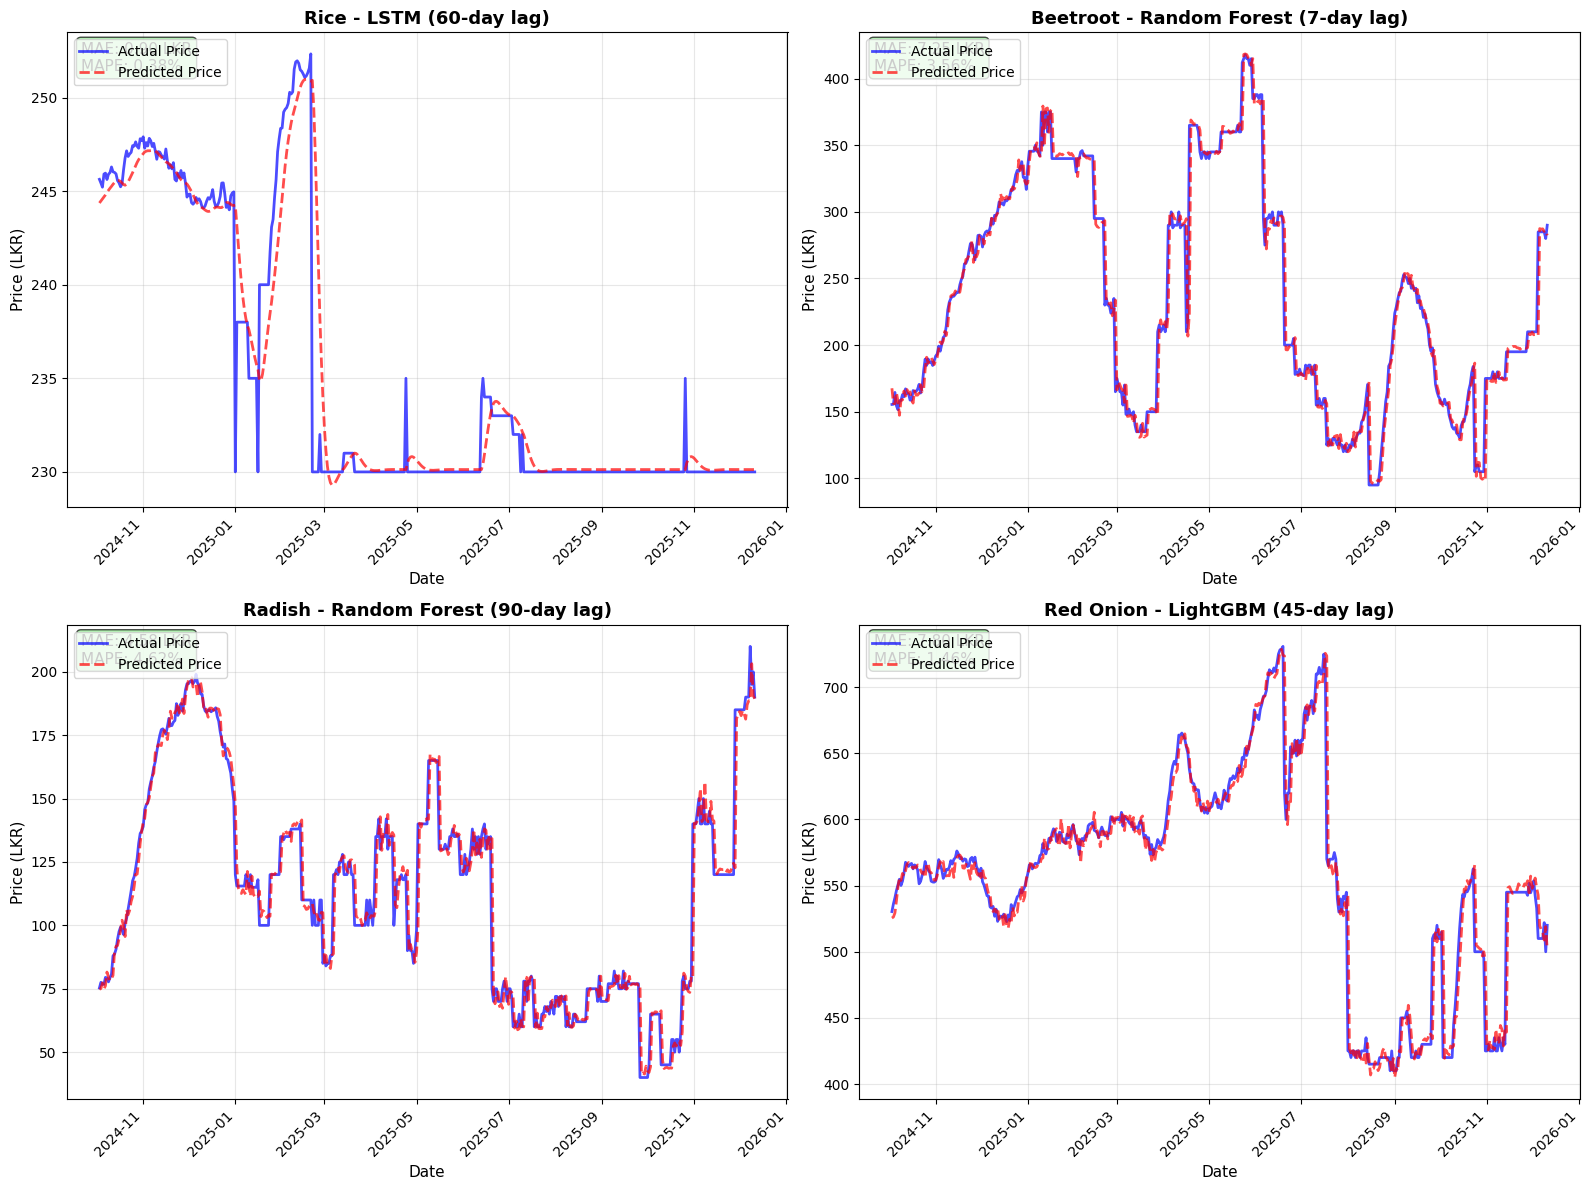


✅ 4-Panel visualization saved to 'prediction_vs_actual_4crop.png'

Summary:
  Rice         -> MAE: 0.90 LKR, MAPE: 0.38%
  Beetroot     -> MAE: 7.25 LKR, MAPE: 3.56%
  Radish       -> MAE: 4.58 LKR, MAPE: 4.62%
  Red Onion    -> MAE: 7.80 LKR, MAPE: 1.46%


In [78]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

crops_order = ['Rice', 'Beetroot', 'Radish', 'Red Onion']
models_info = {
    'Rice': 'LSTM (60-day lag)',
    'Beetroot': 'Random Forest (7-day lag)',
    'Radish': 'Random Forest (90-day lag)',
    'Red Onion': 'LightGBM (45-day lag)'
}

for idx, crop in enumerate(crops_order):
    ax = axes[idx]
    
    if crop in stored_results:
        result = stored_results[crop]
        test_vals = result['test_vals']
        y_pred = result['y_pred']
        test_dates = result['test_dates']
        mae = result['mae']
        mape = result['mape']
        
        # Plot actual vs predicted
        ax.plot(test_dates, test_vals, 'b-', label='Actual Price', linewidth=2, alpha=0.7)
        ax.plot(test_dates, y_pred, 'r--', label='Predicted Price', linewidth=2, alpha=0.7)
        
        # Add metrics box
        metrics_text = f'MAE: {mae:.2f} LKR\nMAPE: {mape:.2f}%'
        ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, 
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        
        # Formatting
        ax.set_title(f'{crop} - {models_info[crop]}', fontsize=13, fontweight='bold')
        ax.set_xlabel('Date', fontsize=11)
        ax.set_ylabel('Price (LKR)', fontsize=11)
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Format x-axis dates
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('prediction_vs_actual_4crop.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 4-Panel visualization saved to 'prediction_vs_actual_4crop.png'")
print("\nSummary:")
for crop in crops_order:
    if crop in stored_results:
        print(f"  {crop:12s} -> MAE: {stored_results[crop]['mae']:.2f} LKR, MAPE: {stored_results[crop]['mape']:.2f}%")